In [1]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


## Roberta Base Model

### setup

In [2]:
import os
import pandas as pd
import numpy as np

import torch

from transformers import AutoTokenizer, AutoModel

from utils import *

import sys
sys.path.append('../datasets')
from mbti_500 import getDataLoaders

In [3]:
# setting the model name
PRE_TRAINED_MODEL_NAME = 'roberta-base'

# setting the dataset
dataset='MBTI 500 multi_label.csv'


# setting the data path
if os.path.exists(f'/datasets/mbti/{dataset}'):
    DATAPATH=f'/datasets/mbti/{dataset}'
else:
    DATAPATH=f'../data/{dataset}'

# setting the checkpoint path 
if os.path.exists('ckpts'):
    CHECKPOINTPATH = 'ckpts/Persnality_MBTI'
else:
    CHECKPOINTPATH = '../ckpts/Persnality_MBTI'

# training parameters
MAX_LEN = 512

# TOKENIZER
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

# setting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# setting the random seed
torch.manual_seed(99)
torch.cuda.manual_seed(99)
torch.cuda.manual_seed_all(99)
np.random.seed(99)

In [4]:
DATAPATH,CHECKPOINTPATH,device

('../data/MBTI 500 multi_label.csv',
 '../ckpts/Persnality_MBTI',
 device(type='cpu'))

### Loading the Data

In [5]:
# load the data
data = pd.read_csv(DATAPATH,encoding='utf-8')

In [6]:
# get the labels list
labels_list = data.columns[2:].tolist()
print(f'Labels list: {labels_list}')

Labels list: ['IE', 'NS', 'TF', 'JP']


In [7]:
data=delete_words(data)

In [8]:
_,_,test_loader = getDataLoaders(data,labels_list,tokenizer,MAX_LEN)

### Load the model

In [9]:
# import model
import sys
sys.path.append('../Models')
import MBTI_model_shap as model


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/omarahmed/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/omarahmed/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
model_no_words = model.ROBERTAClass(PRE_TRAINED_MODEL_NAME)
model_no_words.load_state_dict(torch.load(CHECKPOINTPATH + f'_clean_Best_{PRE_TRAINED_MODEL_NAME}.bin', map_location=torch.device(device)))
model_no_words.to(device)
print(f'{PRE_TRAINED_MODEL_NAME}_no_words loaded')
model_no_words.eval()

torch.set_grad_enabled(False)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


roberta-base_no_words loaded


### predictions

In [11]:
# get the predictions
text,y_pred,_, y_true = get_predictions(model_no_words, test_loader, device)

input_ids shape: torch.Size([32, 512])
attention_mask shape: torch.Size([32, 512])
token_type_ids shape: torch.Size([32, 512])
targets shape: torch.Size([32, 4])
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236


In [65]:
df = pd.DataFrame({'text':text,'IE':y_pred[:,0],'NS':y_pred[:,1],'TF':y_pred[:,2],'JP':y_pred[:,3],'IE_true':y_true[:,0],'NS_true':y_true[:,1],'TF_true':y_true[:,2],'JP_true':y_true[:,3]})
df.to_csv('save_test.csv',index=False)

In [66]:
df.head(n=2)

,text,IE,NS,TF,JP,IE_true,NS_true,TF_true,JP_true
0,diffiuc get sense without actually rift idea l...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
1,quiet one people like reason hard look like ey...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [67]:
# turn all the columns into int type except for the text column
df['IE'] = df['IE'].astype(int)
df['NS'] = df['NS'].astype(int)
df['TF'] = df['TF'].astype(int)
df['JP'] = df['JP'].astype(int)
df['IE_true'] = df['IE_true'].astype(int)
df['NS_true'] = df['NS_true'].astype(int)
df['TF_true'] = df['TF_true'].astype(int)
df['JP_true'] = df['JP_true'].astype(int)

In [68]:
df.head(n=2)

,text,IE,NS,TF,JP,IE_true,NS_true,TF_true,JP_true
0,diffiuc get sense without actually rift idea l...,0,0,0,1,1,0,0,1
1,quiet one people like reason hard look like ey...,1,0,0,0,1,0,0,0


In [69]:
get_accuracy(model_no_words,y_true,y_pred,labels_list,"IE")

Accuracy Scores
0.8685897435897436


{'IE': 0.8685897435897436,
 'NS': 0.9467383107088989,
 'TF': 0.9000754147812972,
 'JP': 0.788367269984917}

### Calculate the Confusion Matrix

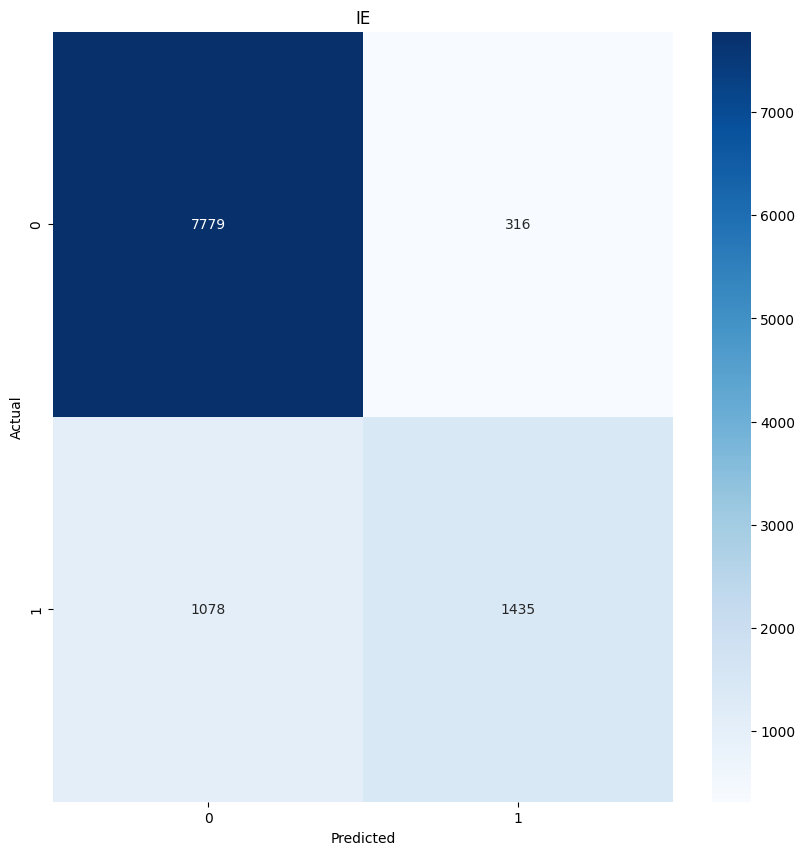

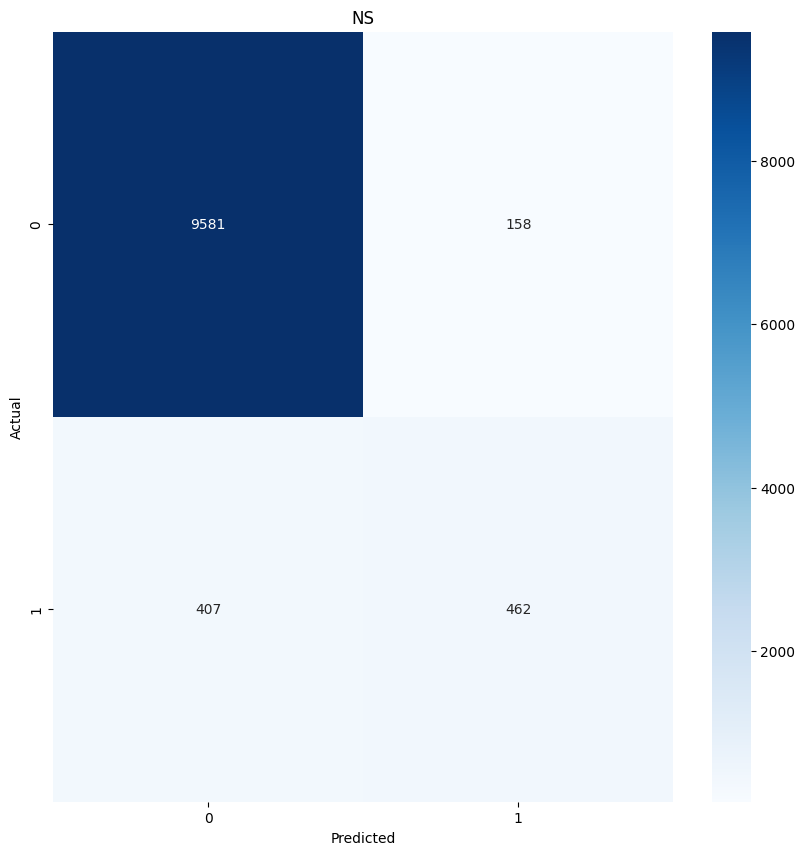

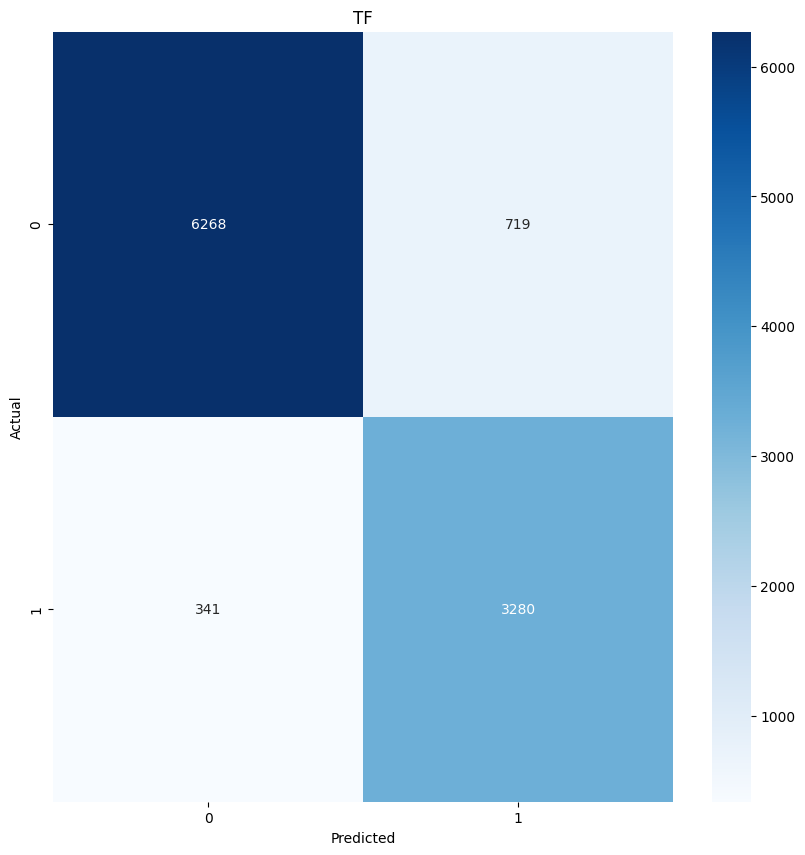

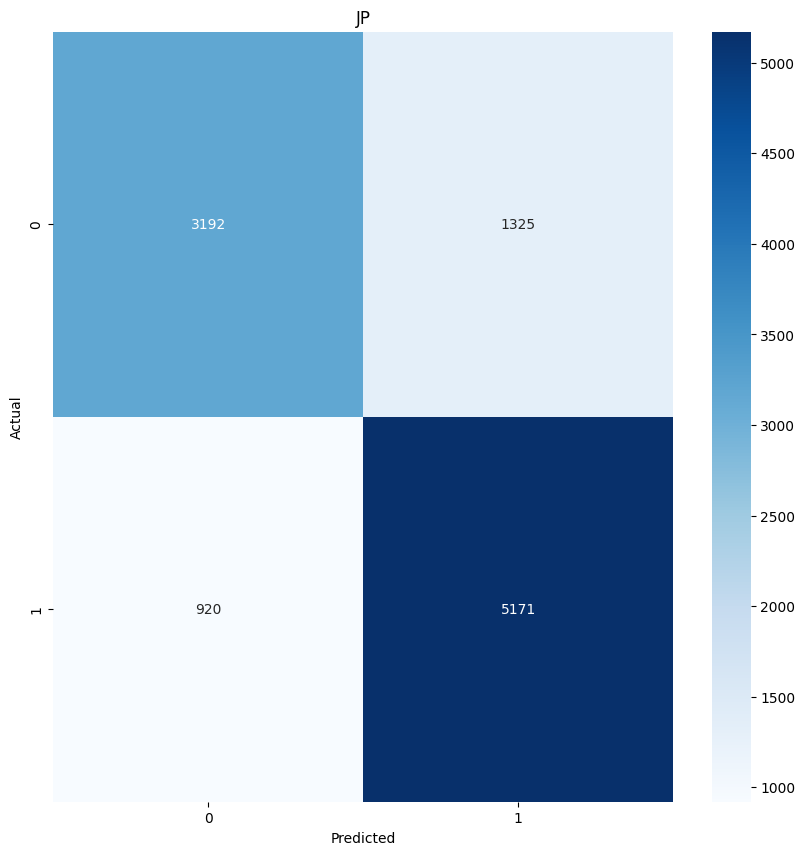

In [24]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title(title)
    plt.show()


plot_confusion_matrix(df['IE_true'],df['IE'],[0,1],"IE")
plot_confusion_matrix(df['NS_true'],df['NS'],[0,1],"NS")
plot_confusion_matrix(df['TF_true'],df['TF'],[0,1],"TF")
plot_confusion_matrix(df['JP_true'],df['JP'],[0,1],"JP")

### Get First 100 correct predictions with equal distribution of classes

In [107]:
# get the correct predictions 
df_correct = df[(df['IE']==df['IE_true']) & (df['NS']==df['NS_true']) & (df['TF']==df['TF_true']) & (df['JP']==df['JP_true'])]

In [116]:
extracted_df = pd.DataFrame(columns=df_correct.columns)
# sort with rows that has 1 in IE, 1 in NS, 1 in TF, 1 in JP
df_correct = df_correct.sort_values(by=['IE','NS','TF','JP'],ascending=False)
# count 0s and 1s
count_0 = [0,0,0,0]
count_1 = [0,0,0,0]
def increment_count(row):
    for i in range(4):
        if row[i]==0:
            count_0[i]+=1
        else:
            count_1[i]+=1
def decrement_count(row):
    for i in range(4):
        if row[i]==0:
            count_0[i]-=1
        else:
            count_1[i]-=1            
for i in range(len(df_correct)):
    increment_count(df_correct.iloc[i][1:5])
    # if any of the counts is greater than 50, do not add the row to the extracted_df
    if count_0[0]>50 or count_0[1]>50 or count_0[2]>50 or count_0[3]>50 or count_1[0]>50 or count_1[1]>50 or count_1[2]>50 or count_1[3]>50:
        decrement_count(df_correct.iloc[i][1:5])
        continue
    # add the row to the extracted_df
    extracted_df=pd.concat([extracted_df,df_correct.iloc[[i]]],ignore_index=True)

/var/folders/9m/_z9mps5d1f70mpcggw5t_pxm0000gn/T/ipykernel_53276/684759519.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if row[i]==0:
/var/folders/9m/_z9mps5d1f70mpcggw5t_pxm0000gn/T/ipykernel_53276/684759519.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if row[i]==0:


In [117]:
count_0,count_1

([50, 50, 50, 50], [50, 50, 50, 50])

In [118]:
extracted_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     100 non-null    object
 1   IE       100 non-null    object
 2   NS       100 non-null    object
 3   TF       100 non-null    object
 4   JP       100 non-null    object
 5   IE_true  100 non-null    object
 6   NS_true  100 non-null    object
 7   TF_true  100 non-null    object
 8   JP_true  100 non-null    object
dtypes: object(9)
memory usage: 7.2+ KB


In [132]:
# calculate the accuracy of the extracted_df
def get_accuracy_extracted_df(df,labels_list):
    accuracy = {}
    for label in labels_list:
        accuracy[label] = (df[label]==df[label+'_true']).sum()/len(df)
    return accuracy

get_accuracy_extracted_df(extracted_df,labels_list)

{'IE': 1.0, 'NS': 1.0, 'TF': 1.0, 'JP': 1.0}

### SHAP

In [129]:
import shap
import pickle as pkl
shap.initjs()

In [196]:
shap_values_IE =model.explain_model(model_no_words,extracted_df["text"],aspect="IE")
# save the shap values
with open('shap_values_IE.pkl', 'wb') as f:
    pkl.dump(shap_values_IE, f)

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   1%|          | 1/100 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   3%|▎         | 3/100 [02:45<1:04:57, 40.18s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   4%|▍         | 4/100 [03:59<1:26:42, 54.19s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   5%|▌         | 5/100 [05:15<1:38:22, 62.14s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   6%|▌         | 6/100 [05:55<1:25:32, 54.60s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   7%|▋         | 7/100 [07:00<1:29:45, 57.91s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   8%|▊         | 8/100 [08:25<1:42:22, 66.77s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   9%|▉         | 9/100 [09:36<1:43:20, 68.14s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  10%|█         | 10/100 [10:10<1:26:22, 57.58s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  11%|█         | 11/100 [11:27<1:34:09, 63.48s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  12%|█▏        | 12/100 [12:41<1:38:00, 66.83s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  13%|█▎        | 13/100 [13:56<1:40:09, 69.08s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  14%|█▍        | 14/100 [15:03<1:38:21, 68.62s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  15%|█▌        | 15/100 [15:31<1:19:41, 56.25s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  16%|█▌        | 16/100 [16:43<1:25:34, 61.13s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  17%|█▋        | 17/100 [17:22<1:15:20, 54.46s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  18%|█▊        | 18/100 [17:56<1:05:47, 48.14s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  19%|█▉        | 19/100 [18:45<1:05:22, 48.43s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 20/100 [20:08<1:18:26, 58.83s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  21%|██        | 21/100 [21:49<1:34:07, 71.49s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  22%|██▏       | 22/100 [22:38<1:24:00, 64.62s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  23%|██▎       | 23/100 [23:09<1:10:10, 54.68s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  24%|██▍       | 24/100 [24:12<1:12:26, 57.19s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|██▌       | 25/100 [25:34<1:20:55, 64.73s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  26%|██▌       | 26/100 [26:06<1:07:32, 54.77s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  27%|██▋       | 27/100 [27:22<1:14:22, 61.13s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  28%|██▊       | 28/100 [28:16<1:10:54, 59.10s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  29%|██▉       | 29/100 [29:28<1:14:18, 62.79s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|███       | 30/100 [30:11<1:06:18, 56.83s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  31%|███       | 31/100 [30:53<1:00:24, 52.52s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  32%|███▏      | 32/100 [31:23<51:42, 45.62s/it]  

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  33%|███▎      | 33/100 [32:01<48:31, 43.45s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  34%|███▍      | 34/100 [32:44<47:44, 43.40s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  35%|███▌      | 35/100 [33:18<43:52, 40.50s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  36%|███▌      | 36/100 [34:40<56:30, 52.97s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  37%|███▋      | 37/100 [36:09<1:07:03, 63.87s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  38%|███▊      | 38/100 [37:35<1:12:54, 70.55s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  39%|███▉      | 39/100 [39:00<1:15:51, 74.61s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|████      | 40/100 [39:41<1:04:47, 64.79s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  41%|████      | 41/100 [40:38<1:01:11, 62.23s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  42%|████▏     | 42/100 [41:38<59:42, 61.76s/it]  

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  43%|████▎     | 43/100 [42:00<47:06, 49.59s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  44%|████▍     | 44/100 [43:41<1:00:48, 65.15s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  45%|████▌     | 45/100 [44:54<1:01:49, 67.45s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  46%|████▌     | 46/100 [45:12<47:31, 52.81s/it]  

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  47%|████▋     | 47/100 [45:35<38:32, 43.64s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  48%|████▊     | 48/100 [46:02<33:32, 38.71s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  49%|████▉     | 49/100 [47:12<40:51, 48.07s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 50/100 [48:25<46:22, 55.64s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  51%|█████     | 51/100 [49:06<41:52, 51.28s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  52%|█████▏    | 52/100 [49:19<31:49, 39.78s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  53%|█████▎    | 53/100 [49:48<28:32, 36.43s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  54%|█████▍    | 54/100 [50:13<25:25, 33.17s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  55%|█████▌    | 55/100 [50:27<20:31, 27.37s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  56%|█████▌    | 56/100 [50:38<16:22, 22.33s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  57%|█████▋    | 57/100 [50:57<15:14, 21.28s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  58%|█████▊    | 58/100 [51:24<16:08, 23.05s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  59%|█████▉    | 59/100 [52:01<18:37, 27.26s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 60/100 [52:16<15:47, 23.69s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  61%|██████    | 61/100 [52:44<16:11, 24.92s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  62%|██████▏   | 62/100 [52:55<13:03, 20.62s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  63%|██████▎   | 63/100 [53:33<15:56, 25.85s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  64%|██████▍   | 64/100 [54:16<18:41, 31.15s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  65%|██████▌   | 65/100 [55:03<20:53, 35.82s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  66%|██████▌   | 66/100 [56:05<24:49, 43.82s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  67%|██████▋   | 67/100 [56:35<21:49, 39.67s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  68%|██████▊   | 68/100 [57:18<21:34, 40.45s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  69%|██████▉   | 69/100 [57:29<16:22, 31.68s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|███████   | 70/100 [58:33<20:45, 41.50s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  71%|███████   | 71/100 [58:49<16:16, 33.68s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  72%|███████▏  | 72/100 [58:58<12:17, 26.35s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  73%|███████▎  | 73/100 [1:00:20<19:20, 42.97s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  74%|███████▍  | 74/100 [1:00:31<14:26, 33.35s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|███████▌  | 75/100 [1:01:15<15:16, 36.66s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  76%|███████▌  | 76/100 [1:01:46<13:57, 34.90s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  77%|███████▋  | 77/100 [1:01:59<10:51, 28.35s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  78%|███████▊  | 78/100 [1:03:01<14:09, 38.63s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  79%|███████▉  | 79/100 [1:04:06<16:11, 46.27s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 80/100 [1:04:42<14:23, 43.19s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  81%|████████  | 81/100 [1:05:24<13:38, 43.05s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  82%|████████▏ | 82/100 [1:06:26<14:37, 48.75s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  83%|████████▎ | 83/100 [1:06:50<11:38, 41.11s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  84%|████████▍ | 84/100 [1:07:54<12:48, 48.06s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  85%|████████▌ | 85/100 [1:08:37<11:40, 46.70s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  86%|████████▌ | 86/100 [1:08:58<09:04, 38.91s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  87%|████████▋ | 87/100 [1:09:25<07:40, 35.39s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  88%|████████▊ | 88/100 [1:09:39<05:46, 28.88s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  89%|████████▉ | 89/100 [1:10:40<07:02, 38.42s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|█████████ | 90/100 [1:11:31<07:02, 42.23s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  91%|█████████ | 91/100 [1:11:45<05:05, 33.90s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  92%|█████████▏| 92/100 [1:12:31<05:00, 37.54s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  93%|█████████▎| 93/100 [1:13:47<05:42, 48.93s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  94%|█████████▍| 94/100 [1:14:13<04:12, 42.04s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  95%|█████████▌| 95/100 [1:14:46<03:16, 39.35s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  96%|█████████▌| 96/100 [1:15:24<02:35, 38.89s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  97%|█████████▋| 97/100 [1:15:54<01:49, 36.39s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  98%|█████████▊| 98/100 [1:16:13<01:02, 31.06s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  99%|█████████▉| 99/100 [1:16:37<00:28, 28.90s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 100/100 [1:17:15<00:00, 31.65s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 101it [1:17:35, 46.55s/it]                         


In [197]:
shap_values_NS =model.explain_model(model_no_words,extracted_df["text"],aspect="NS")
# save the shap values
with open('shap_values_NS.pkl', 'wb') as f:
    pkl.dump(shap_values_NS, f)

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   1%|          | 1/100 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   3%|▎         | 3/100 [02:32<50:19, 31.12s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   4%|▍         | 4/100 [03:59<1:27:14, 54.53s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   5%|▌         | 5/100 [05:08<1:34:31, 59.69s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   6%|▌         | 6/100 [05:31<1:13:39, 47.02s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   7%|▋         | 7/100 [06:32<1:19:55, 51.56s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   8%|▊         | 8/100 [07:41<1:28:02, 57.42s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   9%|▉         | 9/100 [09:08<1:41:17, 66.78s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  10%|█         | 10/100 [09:40<1:23:34, 55.72s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  11%|█         | 11/100 [10:13<1:12:23, 48.81s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  12%|█▏        | 12/100 [11:36<1:27:03, 59.36s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  13%|█▎        | 13/100 [12:19<1:18:39, 54.25s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  14%|█▍        | 14/100 [12:48<1:06:59, 46.74s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  15%|█▌        | 15/100 [13:14<57:11, 40.37s/it]  

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  16%|█▌        | 16/100 [14:24<1:09:18, 49.50s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  17%|█▋        | 17/100 [14:52<59:28, 42.99s/it]  

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  18%|█▊        | 18/100 [15:31<57:00, 41.71s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  19%|█▉        | 19/100 [15:52<48:02, 35.59s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 20/100 [16:31<48:41, 36.52s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  21%|██        | 21/100 [17:01<45:40, 34.69s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  22%|██▏       | 22/100 [17:27<41:38, 32.04s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  23%|██▎       | 23/100 [17:45<35:32, 27.70s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  24%|██▍       | 24/100 [18:46<47:53, 37.82s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|██▌       | 25/100 [19:15<44:01, 35.22s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  26%|██▌       | 26/100 [19:40<39:35, 32.10s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  27%|██▋       | 27/100 [20:06<36:52, 30.31s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  28%|██▊       | 28/100 [21:10<48:24, 40.34s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  29%|██▉       | 29/100 [22:14<55:58, 47.30s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|███       | 30/100 [22:44<49:17, 42.25s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  31%|███       | 31/100 [23:03<40:38, 35.35s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  32%|███▏      | 32/100 [23:33<37:57, 33.49s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  33%|███▎      | 33/100 [24:16<40:46, 36.51s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  34%|███▍      | 34/100 [25:17<48:15, 43.87s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  35%|███▌      | 35/100 [27:08<1:09:22, 64.04s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  36%|███▌      | 36/100 [27:39<57:33, 53.96s/it]  

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  37%|███▋      | 37/100 [28:12<50:01, 47.64s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  38%|███▊      | 38/100 [28:42<43:55, 42.51s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  39%|███▉      | 39/100 [29:18<41:10, 40.50s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|████      | 40/100 [30:05<42:33, 42.56s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  41%|████      | 41/100 [31:12<48:49, 49.66s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  42%|████▏     | 42/100 [33:03<1:05:48, 68.08s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  43%|████▎     | 43/100 [33:53<59:32, 62.67s/it]  

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  44%|████▍     | 44/100 [35:27<1:07:20, 72.15s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  45%|████▌     | 45/100 [36:39<1:06:12, 72.23s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  46%|████▌     | 46/100 [37:00<50:57, 56.63s/it]  

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  47%|████▋     | 47/100 [37:31<43:27, 49.20s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  48%|████▊     | 48/100 [38:02<37:42, 43.52s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  49%|████▉     | 49/100 [38:37<34:58, 41.15s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 50/100 [39:31<37:22, 44.84s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  51%|█████     | 51/100 [40:09<35:01, 42.88s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  52%|█████▏    | 52/100 [40:20<26:36, 33.27s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  53%|█████▎    | 53/100 [40:38<22:27, 28.67s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  54%|█████▍    | 54/100 [40:51<18:21, 23.95s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  55%|█████▌    | 55/100 [41:06<16:00, 21.35s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  56%|█████▌    | 56/100 [41:55<21:48, 29.74s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  57%|█████▋    | 57/100 [42:10<18:08, 25.30s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  58%|█████▊    | 58/100 [42:19<14:18, 20.43s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  59%|█████▉    | 59/100 [42:37<13:19, 19.50s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 60/100 [43:19<17:28, 26.21s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  61%|██████    | 61/100 [43:30<14:11, 21.82s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  62%|██████▏   | 62/100 [43:51<13:32, 21.39s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  63%|██████▎   | 63/100 [44:09<12:39, 20.53s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  64%|██████▍   | 64/100 [44:24<11:22, 18.96s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  65%|██████▌   | 65/100 [44:40<10:23, 17.81s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  66%|██████▌   | 66/100 [44:59<10:23, 18.34s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  67%|██████▋   | 67/100 [45:19<10:19, 18.78s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  68%|██████▊   | 68/100 [46:04<14:13, 26.67s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  69%|██████▉   | 69/100 [46:17<11:40, 22.59s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|███████   | 70/100 [46:57<13:51, 27.71s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  71%|███████   | 71/100 [47:15<12:05, 25.02s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  72%|███████▏  | 72/100 [47:27<09:50, 21.07s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  73%|███████▎  | 73/100 [48:02<11:20, 25.20s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  74%|███████▍  | 74/100 [48:11<08:46, 20.26s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|███████▌  | 75/100 [48:58<11:45, 28.22s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  76%|███████▌  | 76/100 [49:09<09:18, 23.25s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  77%|███████▋  | 77/100 [49:20<07:24, 19.34s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  78%|███████▊  | 78/100 [49:35<06:42, 18.29s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  79%|███████▉  | 79/100 [49:56<06:36, 18.86s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 80/100 [50:09<05:45, 17.26s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  81%|████████  | 81/100 [51:26<11:09, 35.23s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  82%|████████▏ | 82/100 [51:41<08:42, 29.00s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  83%|████████▎ | 83/100 [51:51<06:36, 23.34s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  84%|████████▍ | 84/100 [52:02<05:15, 19.74s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  85%|████████▌ | 85/100 [52:12<04:13, 16.87s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  86%|████████▌ | 86/100 [52:35<04:18, 18.45s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  87%|████████▋ | 87/100 [52:51<03:51, 17.83s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  88%|████████▊ | 88/100 [53:04<03:18, 16.51s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  89%|████████▉ | 89/100 [53:35<03:47, 20.73s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|█████████ | 90/100 [53:45<02:56, 17.64s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  91%|█████████ | 91/100 [53:54<02:15, 15.01s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  92%|█████████▏| 92/100 [54:05<01:49, 13.65s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  93%|█████████▎| 93/100 [54:21<01:41, 14.49s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  94%|█████████▍| 94/100 [54:36<01:27, 14.62s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  95%|█████████▌| 95/100 [55:22<01:59, 23.96s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  96%|█████████▌| 96/100 [55:39<01:27, 21.94s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  97%|█████████▋| 97/100 [55:48<00:54, 18.02s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  98%|█████████▊| 98/100 [57:08<01:13, 36.58s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  99%|█████████▉| 99/100 [57:23<00:30, 30.27s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 100/100 [57:46<00:00, 27.94s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 101it [58:23, 35.04s/it]                         


In [198]:
shap_values_TF =model.explain_model(model_no_words,extracted_df["text"],aspect="TF")
# save the shap values
with open('shap_values_TF.pkl', 'wb') as f:
    pkl.dump(shap_values_TF, f)

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   1%|          | 1/100 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   3%|▎         | 3/100 [02:39<52:45, 32.64s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   4%|▍         | 4/100 [03:52<1:18:59, 49.37s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   5%|▌         | 5/100 [05:13<1:36:49, 61.16s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   6%|▌         | 6/100 [05:28<1:11:03, 45.36s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   7%|▋         | 7/100 [05:48<57:09, 36.88s/it]  

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   8%|▊         | 8/100 [06:14<50:56, 33.22s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   9%|▉         | 9/100 [06:34<44:02, 29.04s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  10%|█         | 10/100 [06:50<37:33, 25.04s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  11%|█         | 11/100 [07:05<32:35, 21.97s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  12%|█▏        | 12/100 [07:40<38:01, 25.92s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  13%|█▎        | 13/100 [07:54<32:39, 22.52s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  14%|█▍        | 14/100 [08:09<28:57, 20.20s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  15%|█▌        | 15/100 [08:27<27:28, 19.40s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  16%|█▌        | 16/100 [09:08<36:19, 25.95s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  17%|█▋        | 17/100 [09:22<30:50, 22.29s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  18%|█▊        | 18/100 [09:38<28:11, 20.63s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  19%|█▉        | 19/100 [09:54<25:42, 19.05s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 20/100 [10:43<37:22, 28.04s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  21%|██        | 21/100 [11:13<37:36, 28.57s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  22%|██▏       | 22/100 [11:26<31:11, 24.00s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  23%|██▎       | 23/100 [11:38<26:20, 20.52s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  24%|██▍       | 24/100 [11:52<23:20, 18.43s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|██▌       | 25/100 [12:20<26:48, 21.45s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  26%|██▌       | 26/100 [12:33<23:00, 18.66s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  27%|██▋       | 27/100 [12:47<21:13, 17.45s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  28%|██▊       | 28/100 [13:06<21:17, 17.74s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  29%|██▉       | 29/100 [13:19<19:17, 16.30s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|███       | 30/100 [13:47<23:20, 20.01s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  31%|███       | 31/100 [14:02<21:06, 18.36s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  32%|███▏      | 32/100 [14:29<23:59, 21.18s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  33%|███▎      | 33/100 [14:45<21:41, 19.43s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  34%|███▍      | 34/100 [15:16<25:19, 23.02s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  35%|███▌      | 35/100 [15:31<22:19, 20.61s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  36%|███▌      | 36/100 [16:06<26:38, 24.97s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  37%|███▋      | 37/100 [16:20<22:39, 21.59s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  38%|███▊      | 38/100 [16:32<19:18, 18.69s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  39%|███▉      | 39/100 [16:48<18:09, 17.86s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|████      | 40/100 [17:23<23:01, 23.03s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  41%|████      | 41/100 [17:36<19:35, 19.92s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  42%|████▏     | 42/100 [18:09<23:12, 24.01s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  43%|████▎     | 43/100 [18:24<20:06, 21.17s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  44%|████▍     | 44/100 [19:25<31:05, 33.31s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  45%|████▌     | 45/100 [19:41<25:42, 28.05s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  46%|████▌     | 46/100 [19:55<21:26, 23.82s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  47%|████▋     | 47/100 [20:12<19:11, 21.73s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  48%|████▊     | 48/100 [20:23<15:56, 18.40s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  49%|████▉     | 49/100 [20:45<16:36, 19.53s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 50/100 [21:01<15:28, 18.57s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  51%|█████     | 51/100 [21:29<17:20, 21.23s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  52%|█████▏    | 52/100 [22:43<29:38, 37.05s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  53%|█████▎    | 53/100 [24:16<42:13, 53.91s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  54%|█████▍    | 54/100 [25:03<39:41, 51.76s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  55%|█████▌    | 55/100 [26:18<44:05, 58.79s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  56%|█████▌    | 56/100 [26:47<36:38, 49.96s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  57%|█████▋    | 57/100 [27:13<30:37, 42.74s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  58%|█████▊    | 58/100 [27:28<24:05, 34.42s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  59%|█████▉    | 59/100 [27:50<20:56, 30.64s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 60/100 [28:41<24:34, 36.85s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  61%|██████    | 61/100 [29:31<26:24, 40.64s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  62%|██████▏   | 62/100 [30:56<34:14, 54.06s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  63%|██████▎   | 63/100 [31:29<29:22, 47.63s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  64%|██████▍   | 64/100 [32:04<26:23, 43.99s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  65%|██████▌   | 65/100 [32:41<24:20, 41.73s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  66%|██████▌   | 66/100 [33:10<21:29, 37.93s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  67%|██████▋   | 67/100 [34:05<23:42, 43.11s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  68%|██████▊   | 68/100 [34:36<21:02, 39.45s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  69%|██████▉   | 69/100 [35:24<21:41, 41.97s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|███████   | 70/100 [36:35<25:26, 50.89s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  71%|███████   | 71/100 [37:02<21:07, 43.70s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  72%|███████▏  | 72/100 [37:51<21:04, 45.16s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  73%|███████▎  | 73/100 [39:29<27:26, 60.98s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  74%|███████▍  | 74/100 [39:56<22:02, 50.85s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|███████▌  | 75/100 [40:35<19:41, 47.26s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  76%|███████▌  | 76/100 [41:12<17:38, 44.11s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  77%|███████▋  | 77/100 [41:24<13:15, 34.57s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  78%|███████▊  | 78/100 [42:39<17:08, 46.76s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  79%|███████▉  | 79/100 [44:24<22:26, 64.13s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 80/100 [44:56<18:12, 54.61s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  81%|████████  | 81/100 [45:29<15:11, 47.96s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  82%|████████▏ | 82/100 [46:02<13:06, 43.68s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  83%|████████▎ | 83/100 [46:35<11:24, 40.27s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  84%|████████▍ | 84/100 [46:59<09:26, 35.43s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  85%|████████▌ | 85/100 [48:19<12:13, 48.91s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  86%|████████▌ | 86/100 [49:09<11:27, 49.10s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  87%|████████▋ | 87/100 [49:28<08:40, 40.07s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  88%|████████▊ | 88/100 [50:30<09:20, 46.68s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  89%|████████▉ | 89/100 [51:04<07:53, 43.02s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|█████████ | 90/100 [52:01<07:51, 47.10s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  91%|█████████ | 91/100 [52:42<06:49, 45.48s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  92%|█████████▏| 92/100 [53:02<05:01, 37.64s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  93%|█████████▎| 93/100 [54:33<06:16, 53.81s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  94%|█████████▍| 94/100 [54:53<04:20, 43.47s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  95%|█████████▌| 95/100 [55:17<03:08, 37.67s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  96%|█████████▌| 96/100 [55:54<02:30, 37.65s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  97%|█████████▋| 97/100 [57:05<02:22, 47.60s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  98%|█████████▊| 98/100 [57:46<01:31, 45.64s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  99%|█████████▉| 99/100 [58:18<00:41, 41.49s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 100/100 [58:57<00:00, 40.70s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 101it [59:52, 35.92s/it]                         


In [199]:
shap_values_JP =model.explain_model(model_no_words,extracted_df["text"],aspect="JP")
# save the shap values
with open('shap_values_JP.pkl', 'wb') as f:
    pkl.dump(shap_values_JP, f)

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   1%|          | 1/100 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   3%|▎         | 3/100 [01:45<44:34, 27.57s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   4%|▍         | 4/100 [02:08<41:38, 26.03s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   5%|▌         | 5/100 [03:26<1:11:43, 45.30s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   6%|▌         | 6/100 [03:39<53:12, 33.96s/it]  

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   7%|▋         | 7/100 [04:38<1:05:39, 42.36s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   8%|▊         | 8/100 [05:50<1:19:30, 51.86s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   9%|▉         | 9/100 [06:42<1:18:33, 51.80s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  10%|█         | 10/100 [07:08<1:05:58, 43.99s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  11%|█         | 11/100 [07:25<52:37, 35.48s/it]  

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  12%|█▏        | 12/100 [08:59<1:18:10, 53.30s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  13%|█▎        | 13/100 [09:32<1:08:22, 47.16s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  14%|█▍        | 14/100 [09:56<57:46, 40.31s/it]  

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  15%|█▌        | 15/100 [10:22<50:57, 35.97s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  16%|█▌        | 16/100 [10:49<46:35, 33.28s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  17%|█▋        | 17/100 [11:12<41:51, 30.25s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  18%|█▊        | 18/100 [11:52<45:09, 33.04s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  19%|█▉        | 19/100 [12:09<38:09, 28.26s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 20/100 [13:04<48:17, 36.22s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  21%|██        | 21/100 [13:29<43:34, 33.09s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  22%|██▏       | 22/100 [13:47<36:56, 28.41s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  23%|██▎       | 23/100 [14:03<31:50, 24.81s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  24%|██▍       | 24/100 [14:30<32:00, 25.26s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|██▌       | 25/100 [14:44<27:19, 21.86s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  26%|██▌       | 26/100 [15:01<25:27, 20.65s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  27%|██▋       | 27/100 [15:20<24:20, 20.01s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  28%|██▊       | 28/100 [16:04<32:37, 27.18s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  29%|██▉       | 29/100 [16:18<27:40, 23.38s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|███       | 30/100 [16:46<28:52, 24.74s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  31%|███       | 31/100 [17:01<24:51, 21.62s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  32%|███▏      | 32/100 [17:17<22:50, 20.15s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  33%|███▎      | 33/100 [17:37<22:14, 19.92s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  34%|███▍      | 34/100 [18:06<24:51, 22.60s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  35%|███▌      | 35/100 [18:32<25:37, 23.65s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  36%|███▌      | 36/100 [18:51<23:42, 22.22s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  37%|███▋      | 37/100 [19:06<21:09, 20.15s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  38%|███▊      | 38/100 [19:34<23:21, 22.60s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  39%|███▉      | 39/100 [19:48<20:11, 19.85s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|████      | 40/100 [20:24<24:52, 24.88s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  41%|████      | 41/100 [20:53<25:34, 26.00s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  42%|████▏     | 42/100 [21:51<34:19, 35.52s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  43%|████▎     | 43/100 [22:05<27:40, 29.14s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  44%|████▍     | 44/100 [23:06<36:02, 38.61s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  45%|████▌     | 45/100 [24:01<40:02, 43.69s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  46%|████▌     | 46/100 [24:22<33:02, 36.72s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  47%|████▋     | 47/100 [24:47<29:32, 33.44s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  48%|████▊     | 48/100 [25:21<28:58, 33.42s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  49%|████▉     | 49/100 [25:46<26:24, 31.06s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 50/100 [26:24<27:35, 33.11s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  51%|█████     | 51/100 [27:00<27:35, 33.78s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  52%|█████▏    | 52/100 [27:46<30:01, 37.52s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  53%|█████▎    | 53/100 [28:48<35:15, 45.01s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  54%|█████▍    | 54/100 [29:26<32:45, 42.73s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  55%|█████▌    | 55/100 [30:38<38:48, 51.73s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  56%|█████▌    | 56/100 [31:57<43:54, 59.88s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  57%|█████▋    | 57/100 [33:11<45:55, 64.08s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  58%|█████▊    | 58/100 [34:04<42:27, 60.67s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  59%|█████▉    | 59/100 [35:10<42:27, 62.14s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 60/100 [35:58<38:46, 58.17s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  61%|██████    | 61/100 [37:21<42:39, 65.63s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  62%|██████▏   | 62/100 [38:12<38:42, 61.12s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  63%|██████▎   | 63/100 [39:07<36:30, 59.19s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  64%|██████▍   | 64/100 [39:49<32:29, 54.16s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  65%|██████▌   | 65/100 [40:45<31:51, 54.61s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  66%|██████▌   | 66/100 [42:10<36:12, 63.89s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  67%|██████▋   | 67/100 [43:23<36:38, 66.61s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  68%|██████▊   | 68/100 [44:41<37:15, 69.85s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  69%|██████▉   | 69/100 [45:11<29:54, 57.89s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|███████   | 70/100 [46:24<31:11, 62.40s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  71%|███████   | 71/100 [47:28<30:23, 62.88s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  72%|███████▏  | 72/100 [48:15<27:12, 58.32s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  73%|███████▎  | 73/100 [49:32<28:42, 63.81s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  74%|███████▍  | 74/100 [50:02<23:13, 53.61s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|███████▌  | 75/100 [51:08<23:57, 57.52s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  76%|███████▌  | 76/100 [52:13<23:49, 59.57s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  77%|███████▋  | 77/100 [53:37<25:38, 66.91s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  78%|███████▊  | 78/100 [55:24<28:59, 79.06s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  79%|███████▉  | 79/100 [57:04<29:49, 85.23s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 80/100 [58:18<27:19, 81.96s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  81%|████████  | 81/100 [59:25<24:31, 77.45s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  82%|████████▏ | 82/100 [1:00:44<23:22, 77.93s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  83%|████████▎ | 83/100 [1:01:16<18:11, 64.19s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  84%|████████▍ | 84/100 [1:02:01<15:32, 58.25s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  85%|████████▌ | 85/100 [1:03:27<16:40, 66.70s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  86%|████████▌ | 86/100 [1:04:45<16:20, 70.02s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  87%|████████▋ | 87/100 [1:05:14<12:32, 57.88s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  88%|████████▊ | 88/100 [1:06:02<10:58, 54.91s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  89%|████████▉ | 89/100 [1:07:19<11:15, 61.39s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|█████████ | 90/100 [1:08:50<11:42, 70.24s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  91%|█████████ | 91/100 [1:10:06<10:47, 72.00s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  92%|█████████▏| 92/100 [1:11:32<10:10, 76.37s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  93%|█████████▎| 93/100 [1:12:49<08:55, 76.49s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  94%|█████████▍| 94/100 [1:14:16<07:57, 79.65s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  95%|█████████▌| 95/100 [1:15:35<06:36, 79.38s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  96%|█████████▌| 96/100 [1:16:46<05:07, 76.80s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  97%|█████████▋| 97/100 [1:17:27<03:18, 66.18s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  98%|█████████▊| 98/100 [1:18:55<02:25, 72.67s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  99%|█████████▉| 99/100 [1:20:29<01:19, 79.02s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 100/100 [1:21:48<00:00, 79.04s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 101it [1:23:18, 49.98s/it]                         


### Remove the top 100 features and check the performance

In [200]:
# add a column to the extracted_df that contains with the text with the most important 100 tokens removed 
def remove_words(text,words):
    for word in words:
        text = text.replace(word,'')
        # remove extra spaces
        text = ' '.join(text.split())
    return text
def remove_100_tokens(shap_values,aspect,asc=False):
    for i in range(len(shap_values)):
        feature_importance = pd.DataFrame(list(zip(shap_values_IE[i].data, shap_values_IE[i].values)),
                                 columns=['col_name','feature_importance_vals'])
        # create a new column with the the feauture imp values using the feature_importance_vals column [0]
        feature_importance['feature_importance'] = feature_importance['feature_importance_vals'].apply(lambda x: x[0])
        # sort on the feature_importance column
        feature_importance = feature_importance.sort_values(by='feature_importance',ascending=asc)
        extracted_df.loc[i,aspect+'_no_words'] = remove_words(extracted_df.loc[i,'text'],feature_importance['col_name'].values[0:100])

In [201]:
remove_100_tokens(shap_values_IE,"IE")
remove_100_tokens(shap_values_NS,"NS")
remove_100_tokens(shap_values_TF,"TF")
remove_100_tokens(shap_values_JP,"JP")

### Calculate the performance metrics for each class

In [202]:
# import model
import sys
sys.path.append('../Models')
import roberta_mbti as model

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/omarahmed/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/omarahmed/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [203]:
roberta_model = model.ROBERTAClass(PRE_TRAINED_MODEL_NAME)
roberta_model.load_state_dict(torch.load(CHECKPOINTPATH + f'_clean_Best_{PRE_TRAINED_MODEL_NAME}.bin', map_location=torch.device(device)))
roberta_model.to(device)
print(f'{PRE_TRAINED_MODEL_NAME}_no_words loaded')
roberta_model.eval()

torch.set_grad_enabled(False)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


roberta-base_no_words loaded


In [204]:
# get the predictions for the extracted_df IE_no_words , NS_no_words , TF_no_words , JP_no_words
IE_no_words_pred=roberta_model.getPrediction(extracted_df['IE_no_words'].to_list())
NS_no_words_pred=roberta_model.getPrediction(extracted_df['NS_no_words'].to_list())
TF_no_words_pred=roberta_model.getPrediction(extracted_df['TF_no_words'].to_list())
JP_no_words_pred=roberta_model.getPrediction(extracted_df['JP_no_words'].to_list())

In [206]:
# round the predictions
IE_no_words_pred = np.round(IE_no_words_pred)
NS_no_words_pred = np.round(NS_no_words_pred)
TF_no_words_pred = np.round(TF_no_words_pred)
JP_no_words_pred = np.round(JP_no_words_pred)

In [216]:
# add the predictions of the extracted_df IE_no_words , NS_no_words , TF_no_words , JP_no_words for each of the aspects
extracted_df['IE_no_words_pred'] = IE_no_words_pred[:,0]
extracted_df['NS_no_words_pred'] = NS_no_words_pred[:,1]
extracted_df['TF_no_words_pred'] = TF_no_words_pred[:,2]
extracted_df['JP_no_words_pred'] = JP_no_words_pred[:,3]

In [218]:
# change the columns to int
extracted_df['IE_no_words_pred'] = extracted_df['IE_no_words_pred'].astype(int)
extracted_df['NS_no_words_pred'] = extracted_df['NS_no_words_pred'].astype(int)
extracted_df['TF_no_words_pred'] = extracted_df['TF_no_words_pred'].astype(int)
extracted_df['JP_no_words_pred'] = extracted_df['JP_no_words_pred'].astype(int)

In [219]:
extracted_df.head(n=2)

,text,IE,NS,TF,JP,IE_true,NS_true,TF_true,JP_true,IE_no_words,NS_no_words,TF_no_words,JP_no_words,IE_no_words_pred,NS_no_words_pred,TF_no_words_pred,JP_no_words_pred
0,soon anyways even technology may thing make ha...,1,1,1,1,1,1,1,1,soon anywaytechnology may thing long give figh...,soon anywaytechnology may thing long give figh...,soon anywaytechnology may thing long give figh...,soon anywaytechnology may thing long give figh...,1,0,0,1
1,worry sure come across article sooner late pos...,1,1,1,1,1,1,1,1,website nearly enough argue internet everyone ...,website nearly enough argue internet everyone ...,website nearly enough argue internet everyone ...,website nearly enough argue internet everyone ...,1,0,0,1


In [221]:
# calculate the accuracy of the extracted_df
def get_accuracy_extracted_df_after(df,labels_list):
    accuracy = {}
    for label in labels_list:
        accuracy[label] = (df[label+'_no_words_pred']==df[label+'_true']).sum()/len(df)
    return accuracy

get_accuracy_extracted_df_after(extracted_df,labels_list)

{'IE': 0.8, 'NS': 0.96, 'TF': 0.79, 'JP': 0.75}

In [222]:
# save the accuracy drop in a json file
import json
accuracy_drop =get_accuracy_extracted_df_after(extracted_df,labels_list)
with open('accuracy_drop.json', 'w') as f:
    json.dump(accuracy_drop, f)
    

In [223]:
# save intermediate results of the extracted_df
extracted_df.to_csv('extracted_df.csv',index=False)